**Introduction : Story of transfer learning in NLP**

In early 2018, Jeremy Howard (co-founder of fast.ai) and Sebastian Ruder introduced the Universal Language Model Fine-tuning for Text Classification (ULMFiT) method. ULMFiT was the first Transfer Learning method applied to NLP. As a result, besides significantly outperforming many state-of-the-art tasks, it allowed, with only 100 labeled examples, to match performances equivalent to models trained on 100× more data.

Since the introduction of ULMFiT, Transfer Learning became very popular in NLP and yet Google (BERT, Transformer-XL, XLNet), Facebook (RoBERTa, XLM) or even OpenAI (GPT, GPT-2) begin to pre-train their own model on very large corpora. This time, instead of using the AWD-LSTM neural network, they all used a more powerful architecture based on the Transformer (cf. [Attention is all you need](https://arxiv.org/abs/1706.03762)).



In [0]:
%%bash
pip install transformers
pip install fastai

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [0]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.60
transformers version : 2.3.0


The Spam or non-Spam detection task 


In [0]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


Text(0.5, 1.0, 'Number of ham and spam messages')

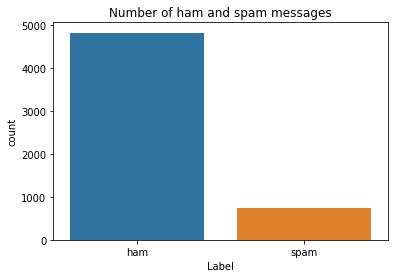

In [0]:
import seaborn as sns
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

**split the data by 80% for train and 20% for test**

In [0]:
msk = np.random.rand(len(df)) < 0.5
train = df[msk]
test = df[~msk]

In [0]:
train.head()

,v1,v2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...


In [0]:
train.to_csv('spam_train.csv', encoding='utf-8', index=False)

In [0]:
test.to_csv('spam_test.csv', encoding='utf-8', index=False)

**Main transformers classes**
In transformers, each model architecture is associated with 3 main types of classes:



*   A tokenizer class to pre-process the data and make it compatible with a particular model.
*   A model class to load/store a particular pre-train model.
*   A configuration class to load/store the configuration of a particular model.

For example, if you want to use the Bert architecture for text classification, you would use BertForSequenceClassification for the model class, BertTokenizer for the tokenizer class and BertConfig for the configuration class. 

In order to switch easily between classes  -  each related to a specific model type  -  I created a dictionary that allows loading the correct classes by just specifying the correct model type name.

In [0]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [0]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [0]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [0]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

It is worth noting that in this case, we use the transformers library only for text classification task. For that reason, this tutorial integrates only the transformer architectures that have a model for sequence classification implemented. These model types are :

*   BERT (from Google)
*   XLNet (from Google/CMU)
*   XLM (from Facebook)
*   RoBERTa (from Facebook)
*   DistilBERT (from HuggingFace)

**Util function**
Function to set the seed for generating random numbers.

In [0]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [0]:
seed_all(seed)

**Data pre-processing**


In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [0]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [0]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [0]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [0]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [0]:
databunch = (TextList.from_df(train, cols='v2', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'v1')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [0]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
"<s> ĠA ĠBoy Ġloved Ġa Ġgal . ĠHe Ġprops d Ġb t Ġshe Ġdidnt Ġmind . ĠHe Ġg v Ġl v Ġl tt rs , ĠB t Ġher Ġfr nd s Ġthrew Ġth m . ĠAgain Ġd Ġboy Ġdecided Ġ2 Ġa pro ach Ġd Ġgal Ġ, Ġd t Ġtime Ġa Ġtruck Ġwas Ġspeeding Ġtowards Ġd Ġgal . ĠW n Ġit Ġwas Ġabout Ġ2 Ġhit Ġd Ġgirl , d Ġboy Ġran",ham
<s> ĠE e Ġmsg Ġna Ġpo ort iy agi Ġo dale bek u : ĠHan uman ji Ġ7 Ġname Ġ1 - Han uman Ġ2 - B aj ar ang ab ali Ġ3 - Mar uti Ġ4 - P avan ap utra Ġ5 - S ank at mo chan Ġ6 - Ram ad uth Ġ7 - Mah ave er Ġe e Ġ7 Ġname Ġ Ġ& lt ; # & gt ;,ham
"<s> ĠDo Ġwhatever Ġyou Ġwant . ĠYou Ġknow Ġwhat Ġthe Ġrules Ġare . ĠWe Ġhad Ġa Ġtalk Ġearlier Ġthis Ġweek Ġabout Ġwhat Ġhad Ġto Ġstart Ġhappening , Ġyou Ġshowing Ġresponsibility . ĠYet , Ġevery Ġweek Ġit 's Ġcan Ġi Ġbend Ġthe Ġrule Ġthis Ġway ? ĠWhat Ġabout Ġthat Ġway ? ĠDo Ġwhatever . ĠI 'm Ġtired Ġof Ġhaving Ġth ia Ġsame Ġargument Ġwith Ġyou Ġevery Ġweek . ĠAnd Ġa Ġ",ham
<s> ĠDo Ġu Ġk on w Ġw ah t Ġis Ġra el ĠFRI EN DS H IP ĠIm Ġg ving Ġy uo Ġan Ġex mp el : ĠJ s ut Ġes e Ġt ih s Ġmsg .. ĠEv rey Ġspl le ing Ġof Ġt ih s Ġmsg Ġis Ġwr n og .. ĠB t Ġsit ll Ġy uo Ġcan Ġra ed Ġit Ġwi ht u ot Ġa yn Ġm its,ham
"<s> ĠHey Ġbabe , Ġsorry Ġi Ġdidn 't Ġget Ġsooner . ĠGary Ġcan Ġcome Ġand Ġfix Ġit Ġcause Ġhe Ġthinks Ġhe Ġknows Ġwhat Ġit Ġis Ġbut Ġhe Ġdoesn 't Ġgo Ġas Ġfar Ġa ĠPt bo Ġand Ġhe Ġsays Ġit Ġwill Ġcost Ġ Ġ& lt ; # & gt ; Ġ Ġbucks . ĠI Ġdon 't Ġknow Ġif Ġit Ġmight Ġbe Ġcheaper Ġto Ġfind Ġsomeone Ġthere Ġ? ĠWe Ġdon 't Ġhave",ham


**Check batch and numericalizer :**

In [0]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 142])
tensor([[    0,    83,  5637,  ...,   398,   113,     2],
        [    0,  1832,  3046,  ...,     1,     1,     1],
        [    0,  1832,  1717,  ...,     1,     1,     1],
        ...,
        [    0, 38343,   534,  ...,     1,     1,     1],
        [    0, 10284,  6006,  ...,     1,     1,     1],
        [    0,  1764,   188,  ...,     1,     1,     1]])


In [0]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [0]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [0]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

**Learner : Custom Optimizer / Custom Metric**

In [0]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [0]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

In [0]:
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [0]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

**Train**

In [0]:
learner.save('untrain')

In [0]:
seed_all(seed)
learner.load('untrain');

In [0]:
learner.freeze_to(-1)

In [0]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [142, 768]           38,603,520 False     
______________________________________________________________________
Embedding            [142, 768]           394,752    False     
______________________________________________________________________
Embedding            [142, 768]           768        False     
______________________________________________________________________
LayerNorm            [142, 768]           1,536      False     
______________________________________________________________________
Dropout              [142, 768]           0          False     
______________________________________________________________________
Linear               [142, 768]           590,592    False     
______________________________________________________________________
Linear               [142, 768]           590,592    False     
_______________________________________

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-04
Min loss divided by 10: 3.31E-05


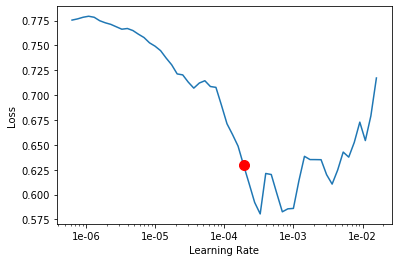

In [0]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.416659,0.321691,0.867925,0.132075,00:02


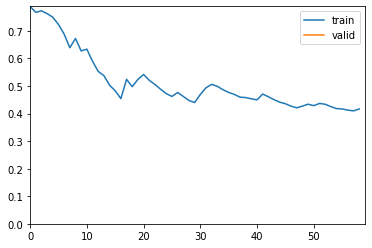

In [0]:
learner.fit_one_cycle(1,max_lr=1e-04,moms=(0.8,0.7))

In [0]:
learner.save('first_cycle')
seed_all(seed)
learner.load('first_cycle');

In [0]:
learner.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.147213,0.249120,0.896226,0.103774,00:03
1,0.094828,0.009418,1.000000,0.000000,00:03
2,0.053107,0.003134,1.000000,0.000000,00:03
3,0.033500,0.004023,1.000000,0.000000,00:03
4,0.022538,0.003292,1.000000,0.000000,00:03


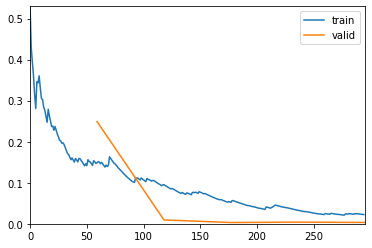

In [0]:
lr = 1e-4
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.121419,1.155320,0.726415,0.273585,00:03
1,0.086137,0.103401,0.943396,0.056604,00:04
2,0.042573,0.003091,1.000000,0.000000,00:03
3,0.019612,0.002976,1.000000,0.000000,00:03
4,0.013912,0.003002,1.000000,0.000000,00:03


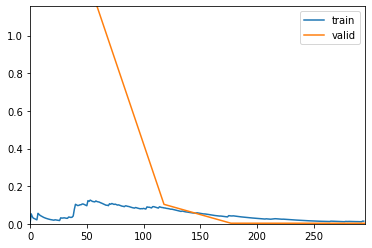

In [0]:
learner.save('second_cycle')
seed_all(seed)
learner.load('second_cycle');
learner.freeze_to(-3)
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [0]:
learner.save('third_cycle')
seed_all(seed)
learner.load('third_cycle');
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.038884,0.003242,1.000000,0.000000,00:09
1,0.149935,0.054197,0.990566,0.009434,00:10
2,0.128090,0.011395,1.000000,0.000000,00:09
3,0.090080,0.099213,0.962264,0.037736,00:09
4,0.076928,0.005218,1.000000,0.000000,00:09
5,0.040349,0.001896,1.000000,0.000000,00:09
6,0.023001,0.000996,1.000000,0.000000,00:10
7,0.010535,0.000896,1.000000,0.000000,00:10
8,0.004157,0.000772,1.000000,0.000000,00:09
9,0.002683,0.000762,1.000000,0.000000,00:09


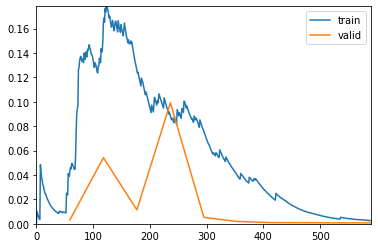

In [0]:
learner.fit_one_cycle(10, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))